今回は avocado の avarage price を予測するモデルを作る。いくつかの変数から avarage price を予測するので回帰の問題である。

## データを手に入れる

In [152]:
import subprocess
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [59]:
KAGGLE_DATASET_NAME = 'neuromusic/avocado-prices'
AVOCADO_PATH = os.path.join("datasets", "avocado")

def fetch_avocado_data(avocado_dataset_name=KAGGLE_DATASET_NAME, avocado_path=AVOCADO_PATH):
    comp = subprocess.run(['kaggle', 'datasets', 'download', '-d', 'neuromusic/avocado-prices', '-p', AVOCADO_PATH])
    if not comp.returncode == 0: raise
    with zipfile.ZipFile(os.path.join(avocado_path, 'avocado-prices.zip')) as existing_zip:
        existing_zip.extractall(avocado_path)

In [60]:
fetch_avocado_data()

In [61]:
import pandas as pd

def load_avocado_data(avocado_path=AVOCADO_PATH):
    csv_path = os.path.join(avocado_path, "avocado.csv")
    return pd.read_csv(csv_path)

In [62]:
avocado = load_avocado_data()

## データ構造をざっと見てみる

In [63]:
avocado.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


4046 , 4225 , 4770 はアボカドのサイズのこと。
Bagsはアボカドが袋詰で販売されている場合の袋のサイズ？。

In [64]:
avocado = avocado.drop(['Unnamed: 0', 'Date'], axis = 1)

In [65]:
avocado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 12 columns):
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: float64(9), int64(1), object(2)
memory usage: 1.7+ MB


In [66]:
avocado.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


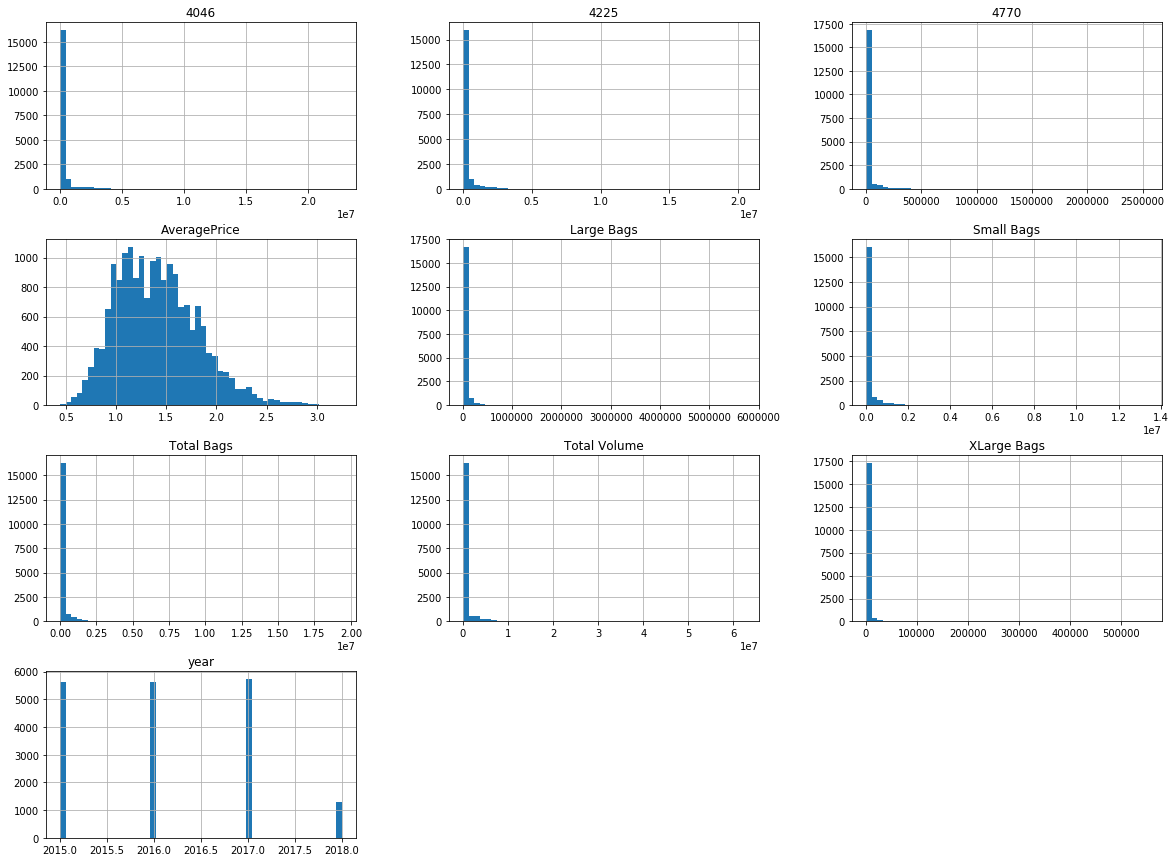

In [67]:
import matplotlib.pyplot as plt

avocado.hist(bins=50, figsize=(20,15))
plt.show()

In [68]:
avocado[avocado['year']==2015].describe()['AveragePrice']

count    5615.000000
mean        1.375590
std         0.375595
min         0.490000
25%         1.070000
50%         1.300000
75%         1.670000
max         2.790000
Name: AveragePrice, dtype: float64

In [69]:
avocado[avocado['year']==2016].describe()['AveragePrice']

count    5616.000000
mean        1.338640
std         0.393708
min         0.510000
25%         1.040000
50%         1.300000
75%         1.560000
max         3.250000
Name: AveragePrice, dtype: float64

In [70]:
avocado[avocado['year']==2017].describe()['AveragePrice']

count    5722.000000
mean        1.515128
std         0.432906
min         0.440000
25%         1.220000
50%         1.490000
75%         1.770000
max         3.170000
Name: AveragePrice, dtype: float64

In [71]:
avocado[avocado['year']==2018].describe()['AveragePrice']

count    1296.000000
mean        1.347531
std         0.305858
min         0.560000
25%         1.130000
50%         1.345000
75%         1.560000
max         2.300000
Name: AveragePrice, dtype: float64

年ごとで価格に差がないかどうか見てみたところ、近年になるにつれて価格が高くなっていくなどの傾向はなかった。もしあったなら、時系列を考慮した分析が必要だが、そういうこともなさそうだ。

## テストセットを作る

In [72]:
from sklearn.model_selection  import train_test_split

train_set, test_set = train_test_split(avocado, test_size=0.2, random_state=42);

## 洞察を得るためにデータを研究、可視化する

In [77]:
avocado = train_set.copy()

In [78]:
avocado.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
16391,1.88,5376.58,147.41,871.40,0.00,4357.77,4351.10,6.67,0.0,organic,2017,Orlando
4990,0.81,578610.94,155537.61,153030.46,21523.37,248519.50,144796.06,103723.44,0.0,conventional,2016,SanDiego
13653,2.01,6470.08,2026.07,2529.20,0.00,1914.81,1848.75,66.06,0.0,organic,2016,PhoenixTucson
2074,1.02,145648.40,78195.76,38763.75,134.25,28554.64,25981.67,2572.97,0.0,conventional,2015,Roanoke
12377,1.53,40535.05,162.25,38677.24,0.00,1695.56,1695.56,0.00,0.0,organic,2016,Chicago


In [79]:
corr_matrix = avocado.corr()
corr_matrix

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
AveragePrice,1.000000,-0.194869,-0.211984,-0.173784,-0.180006,-0.178697,-0.176604,-0.173638,-0.118634,0.091883
Total Volume,-0.194869,1.000000,0.976845,0.974054,0.869199,0.964046,0.968059,0.882444,0.745878,0.013000
4046,-0.211984,0.976845,1.000000,0.922989,0.827669,0.920515,0.925355,0.840607,0.697542,-0.000756
4225,-0.173784,0.974054,0.922989,1.000000,0.884501,0.908151,0.918258,0.812866,0.691372,-0.013627
4770,-0.180006,0.869199,0.827669,0.884501,1.000000,0.791453,0.801168,0.699274,0.689607,-0.039562
Total Bags,-0.178697,0.964046,0.920515,0.908151,0.791453,1.000000,0.994332,0.943484,0.797861,0.067988
Small Bags,-0.176604,0.968059,0.925355,0.918258,0.801168,0.994332,1.000000,0.903210,0.800809,0.060207
Large Bags,-0.173638,0.882444,0.840607,0.812866,0.699274,0.943484,0.903210,1.000000,0.703410,0.084963
XLarge Bags,-0.118634,0.745878,0.697542,0.691372,0.689607,0.797861,0.800809,0.703410,1.000000,0.077101
year,0.091883,0.013000,-0.000756,-0.013627,-0.039562,0.067988,0.060207,0.084963,0.077101,1.000000


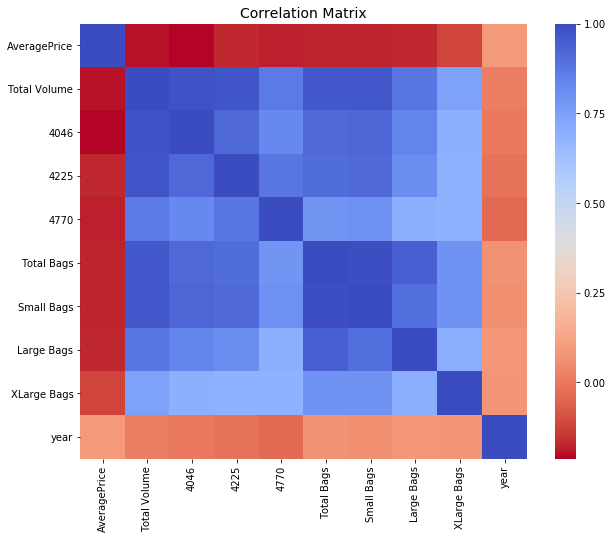

In [80]:
f, ax = plt.subplots(1, 1, figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax)
ax.set_title("Correlation Matrix", fontsize=14)
plt.show()

相関係数を求め、ヒートマップで表示してみた。
AvaragePriceはTotalVolume, 4046 と強い負の相関がある。
TotalVolumeは4046, 4225, Total Bags, Small Bags と強い相関がある。
4046はTotalVolue, TotalBagsなどと強い相関がある。

In [82]:
corr_matrix["AveragePrice"].sort_values(ascending=False)

AveragePrice    1.000000
year            0.091883
XLarge Bags    -0.118634
Large Bags     -0.173638
4225           -0.173784
Small Bags     -0.176604
Total Bags     -0.178697
4770           -0.180006
Total Volume   -0.194869
4046           -0.211984
Name: AveragePrice, dtype: float64

In [86]:
corr_matrix["Total Volume"].sort_values(ascending=False)

Total Volume    1.000000
4046            0.976845
4225            0.974054
Small Bags      0.968059
Total Bags      0.964046
Large Bags      0.882444
4770            0.869199
XLarge Bags     0.745878
year            0.013000
AveragePrice   -0.194869
Name: Total Volume, dtype: float64

In [87]:
corr_matrix["4046"].sort_values(ascending=False)

4046            1.000000
Total Volume    0.976845
Small Bags      0.925355
4225            0.922989
Total Bags      0.920515
Large Bags      0.840607
4770            0.827669
XLarge Bags     0.697542
year           -0.000756
AveragePrice   -0.211984
Name: 4046, dtype: float64

今回は AvaragePrice を予測したいので、4046 や Total Volume, 4770 あたりを特徴量とすると良さそう。

## 機械学習アルゴリズムに渡せるようにデータを準備する

In [93]:
avocado = train_set.drop("AveragePrice", axis=1)
avocado_labels = train_set["AveragePrice"].copy()

In [94]:
avocado.head()

,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
16391,5376.58,147.41,871.40,0.00,4357.77,4351.10,6.67,0.0,organic,2017,Orlando
4990,578610.94,155537.61,153030.46,21523.37,248519.50,144796.06,103723.44,0.0,conventional,2016,SanDiego
13653,6470.08,2026.07,2529.20,0.00,1914.81,1848.75,66.06,0.0,organic,2016,PhoenixTucson
2074,145648.40,78195.76,38763.75,134.25,28554.64,25981.67,2572.97,0.0,conventional,2015,Roanoke
12377,40535.05,162.25,38677.24,0.00,1695.56,1695.56,0.00,0.0,organic,2016,Chicago


## 欠損値を処理する

In [97]:
avocado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14599 entries, 16391 to 15795
Data columns (total 11 columns):
Total Volume    14599 non-null float64
4046            14599 non-null float64
4225            14599 non-null float64
4770            14599 non-null float64
Total Bags      14599 non-null float64
Small Bags      14599 non-null float64
Large Bags      14599 non-null float64
XLarge Bags     14599 non-null float64
type            14599 non-null object
year            14599 non-null int64
region          14599 non-null object
dtypes: float64(8), int64(1), object(2)
memory usage: 1.3+ MB


欠損値はないぞ！

### テキスト/カテゴリ属性の処理

In [112]:
avocado_cat_type = avocado[['type']]
avocado_cat_type.head()

,type
16391,organic
4990,conventional
13653,organic
2074,conventional
12377,organic


In [113]:
from future_encoders import OneHotEncoder

In [117]:
cat_encoder = OneHotEncoder()
avocado_cat_type_1hot = cat_encoder.fit_transform(avocado_cat_type)

In [118]:
avocado_cat_type_1hot.toarray()

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [119]:
avocado_cat_region = avocado[['region']]
avocado_cat_region.head()

,region
16391,Orlando
4990,SanDiego
13653,PhoenixTucson
2074,Roanoke
12377,Chicago


In [120]:
avocado_cat_region_1hot = cat_encoder.fit_transform(avocado_cat_region)

In [121]:
avocado_cat_region_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 変換パイプライン

In [133]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Scikit_Learn 0.20で導入される
from future_encoders import ColumnTransformer
from future_encoders import OneHotEncoder

In [134]:
num_attribs = list(avocado.drop('type', axis=1).drop('region', axis=1))
cat_attribs = ['type', 'region']

In [135]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

In [136]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

In [137]:
avocado_prepared = full_pipeline.fit_transform(avocado)

In [144]:
avocado_prepared.toarray()

array([[-0.24768319, -0.23592794, -0.24551854, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07931228, -0.11092328, -0.11824444, ...,  0.        ,
         0.        ,  0.        ],
       [-0.24736201, -0.23441664, -0.24413186, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.22476383, -0.23524831, -0.20028386, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16773169, -0.20164301, -0.12880609, ...,  0.        ,
         0.        ,  0.        ],
       [-0.24821928, -0.23558958, -0.24506775, ...,  0.        ,
         0.        ,  0.        ]])

In [141]:
avocado_prepared.shape

(14599, 65)

## 訓練セットを訓練、評価する

In [146]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(avocado_prepared, avocado_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [147]:
some_data = avocado.iloc[:5]
some_labels = avocado_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [1.78851062 1.1513875  1.46759741 0.95318092 1.81048629]


In [148]:
print("Labels:", list(some_labels))

Labels: [1.88, 0.81, 2.01, 1.02, 1.53]


In [153]:
from sklearn.metrics import mean_squared_error

avocado_predictions = lin_reg.predict(avocado_prepared)
lin_mse = mean_squared_error(avocado_labels, avocado_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.2672371424877696

In [158]:
avocado_label.describe()

count    14599.000000
mean         1.404860
std          0.403128
min          0.440000
25%          1.100000
50%          1.370000
75%          1.660000
max          3.170000
Name: AveragePrice, dtype: float64

アボカドの値段は 0.4 から 3.17 の間で RMSE が 0.26 であるので良くない。

In [165]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(avocado_prepared, avocado_labels)
avocado_predictions = tree_reg.predict(avocado_prepared)

In [167]:
tree_mse = mean_squared_error(avocado_labels, avocado_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1.0910841122068895e-17

## 交差検証を使ったよりよい評価

In [168]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, avocado_prepared, avocado_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [169]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [170]:
display_scores(tree_rmse_scores)

Scores: [0.22799633 0.21774797 0.21968782 0.21619372 0.22160096 0.21117301
 0.21173953 0.22544355 0.22244932 0.22086874]
Mean: 0.2194900970280448
Standard deviation: 0.005158472739763942


In [171]:
lin_scores = cross_val_score(lin_reg, avocado_prepared, avocado_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.2673856  0.26719627 0.26224417 0.26241816 0.26399083 0.26551427
 0.27533338 0.27624181 0.27651335 0.26682928]
Mean: 0.26836671128432216
Standard deviation: 0.005308210317970786


In [172]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(avocado_prepared, avocado_labels)

housing_predictions = forest_reg.predict(avocado_prepared)
forest_mse = mean_squared_error(avocado_labels, avocado_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/Users/mitsuki/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


1.0910841122068895e-17

In [173]:
forest_scores = cross_val_score(forest_reg, avocado_prepared, avocado_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.16151808 0.15916953 0.15622096 0.16596076 0.16287371 0.157421
 0.16598386 0.17038967 0.16615415 0.15965163]
Mean: 0.1625343340421272
Standard deviation: 0.0043038800650996795


あとはモデルの微調整をして test set で検証して終わりなんだけど、この辺には演習問題とかでなれているし飛ばす。